In [1]:
import math
import matplotlib.pyplot as plt

In [2]:
# Givens
d = 7.94e-3  # [m]
d_tjoin = 11.25e-3  # [m]
L_tjoin = 4e-2  # [m]
sin_theta = 1 / 150  # []
h0, hf = 10e-2, 2e-2  # [m], [m]
L_box, W_box = 32e-2, 26e-2  # [m], [m]
eps = 0.0015e-3  # [m] (surface roughness of PVC pipe)
mu = 0.89e-3  # [Pa * s] (water at 25 degrees C)
mu = 0.0010016  # [Pa * s] (water at 25 degrees C)

## Minor Loss Terms
# Setting the below value to anything other than zero makes the values worse, since the values
# without any minor loss terms are already erring on the longer end of the correct values
K_bucket_to_tube = 0  # []
# From page 378 of Cengel, Yunus, Cimbala
# Minor loss value of 1.1 for 90 degree miter bend without vanes, at least that large
# Minor loss value of 2.0 for tee branch flow, at most that large
K_tee_joint = 1.6  # []

# Constants
rho = 997  # [kg/m^3]
g = 9.81  # [m/s^2]

# Initial Conditions
A_tube = math.pi * d ** 2 / 4  # [m^2]
A_tjoin = 2 * (math.pi * d_tjoin ** 2 / 4)  # [m^2]
A_box = L_box * W_box  # [m^2]
V0 = A_box * (h0 + hf)  # [m^3]

# Final Conditions
VF = A_box * hf

In [3]:
# Experimental Results
results = {
    20: (3, 19),
    30: (3, 34),
    40: (4, 26),
    60: (4, 48)
}
results = {Li * 1e-2: 60 * mins + secs for Li, (mins, secs) in results.items()}

In [4]:
def reynolds_number(v):
    return rho * v * d / mu

def haaland_equation(re):
    inv_sqrt_f = -1.8 * math.log10((eps / d / 3.7) ** 1.1 + 6.9 / re)
    return (1 / inv_sqrt_f) ** 2

def serghides_equation(re):
    A = -2 * math.log10(eps / d / 3.7 + 12 / re)
    B = -2 * math.log10(eps / d / 3.7 + 2.51 * A / re)
    C = -2 * math.log10(eps / d / 3.7 + 2.51 * B / re)
    inv_sqrt_f = A - (B - A) ** 2 / (C - 2 * B + A)
    return (1 / inv_sqrt_f) ** 2

def s_t_min_s(s):
    return f"{s//60}:{(s%60):02}"

def solve(
    l,
    using_tjoint=False,
    f_eqn=haaland_equation, 
    trans_is_turb=True, 
    silent=False,
    verbose=False,
) -> int:
    # TODO: reconsider this line
    # l = l + L_tjoin if using_tjoint else l
    Vi = V0
    Vdot_i = 0
    n = 0
    turb, lam, trans = 0, 0, 0
    delta_t = 0.01  # [s]
    A_cs = A_tjoin if using_tjoint else A_tube
    output = {"data": {}}
    while True:
        n += 1
        Vi += Vdot_i * delta_t  # [m^3/s]
        vi = -Vdot_i / A_cs  # [m/s]
        re = reynolds_number(vi)
        if re > 4000:
            # NOTE:
            # for our small pipe lengths where the flow is entirely turbulent,
            # the model is taking too long for the pipe to drain.
            # Therefore, this is the main culprit for error
            turb += 1
            f = f_eqn(re)
            alpha = 1 / (1 + 0.6 / re ** 0.5)
        elif re > 2300:
            # TODO: what do we do here, not important based on pct in each state but still interesting
            trans += 1
            if trans_is_turb:
                f = f_eqn(re)
                alpha = 1 / (1 + 0.6 / re ** 0.5)
            else:
                f = 64 / (re)
                alpha = 2
        else:
            lam += 1
            f = 64 / (re or 9000)
            alpha = 2
        loss_terms = alpha + l * f / d
        if using_tjoint:
            loss_terms += K_tee_joint
        else:
            loss_terms += K_bucket_to_tube
        Vdot_i = -A_cs * ((Vi / A_box + l / 150) / ((0.5 / g) * loss_terms)) ** 0.5

        output["data"][n] = {"re": re, "volume": Vi, "velocity": vi, "q_dot": Vi}

        if abs((Vi - VF) / VF) < 0.001:
            tf = int(n * delta_t)
            output["time_to_drain"] = tf
            output["timestep"] = delta_t
            if not silent:
                s = f"{l:.02}m => {s_t_min_s(tf)}"
                if not using_tjoint:
                    t_exp = results[l]
                    diff = tf - t_exp
                    s += f" || actual: {s_t_min_s(t_exp)} || diff:{diff: >2}"
                    s += f" || error:{(1 - min(tf / t_exp, t_exp / tf)) * 100:.02}% || k_inv:{int(tf / l)}"
                    s += f" || turb:{(turb / n):.02} trans:{(trans / n):.02}"
                print(s)
            return output
        elif n > 500 / delta_t:
            print("too many steps")
            break

In [5]:
# Haaland vs Serghides || No difference
def compare_haaland_serghides():
    print("Haaland")
    for l in [0.2, 0.3, 0.4, 0.6]:
        solve(l, f_eqn=haaland_equation)
    
    print("Serghides")
    for l in [0.2, 0.3, 0.4, 0.6]:
        solve(l, f_eqn=serghides_equation)

In [6]:
def compare_different_eqns_for_transition_flow():
    print("trans = turb")
    for l in [0.2, 0.3, 0.4, 0.6]:
        solve(l, trans_is_turb=True)
    
    print("trans = lam")
    for l in [0.2, 0.3, 0.4, 0.6]:
        solve(l, trans_is_turb=False)

In [7]:
def compare_straight_tube_vs_tjoin():
    print("just tube")
    for l in [0.2, 0.3, 0.4, 0.6]:
        solve(l, using_tjoint=False)
    
    print("tube with tjoint")
    for l in [0.2, 0.3, 0.4, 0.6]:
        solve(l, using_tjoint=True)

In [8]:
def graph_re(l, **kwargs):
    output = solve(l, **kwargs)
    x = [output["timestep"] * n for n in output["data"].keys()][10:]
    y = [data["re"] for data in output["data"].values()][10:]
    y_const = [4000 for _ in range(len(y))]
    
    plt.plot(x, y)
    plt.plot(x, y_const)
    plt.xlabel("time [s]")
    plt.ylabel("Reynolds number []")
    plt.show()

0.2m => 3:31 || actual: 3:19 || diff:12 || error:5.7% || k_inv:1055 || turb:0.92 trans:0.082


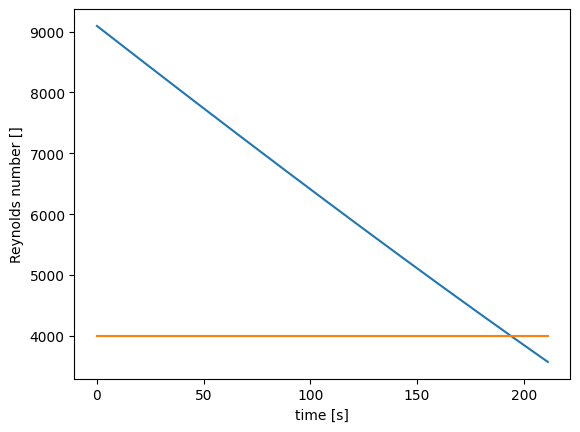

In [9]:
graph_re(0.20)

0.6m => 4:58 || actual: 4:48 || diff:10 || error:3.4% || k_inv:496 || turb:0.61 trans:0.39


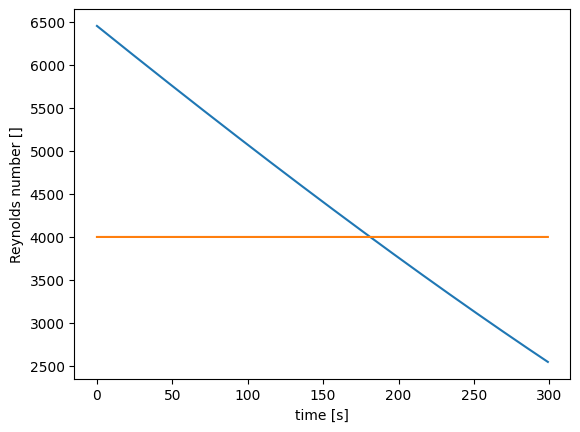

In [10]:
graph_re(0.6)